In [1]:
# nuclio: ignore
import nuclio

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
def _eval_model(context, xtest, ytest, model, score_method="micro", plots_dest=""):
    """internal evaluate one model
    """
    from sklearn import metrics
    from cloudpickle import load
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import label_binarize
    from sklearn.utils.multiclass import unique_labels
    from mlrun.artifacts import PlotArtifact
    from mlrun.mlutils import plot_roc, plot_importance, gcf_clear

    # enclose all except model
    ytestb = label_binarize(ytest, classes=ytest.unique())
    
    context.header = xtest.columns.names
    
    clf = load(open(model, "rb"))
    if callable(getattr(clf, "predict_proba")):
        y_score = clf.predict_proba(xtest.values)
        ypred = clf.predict(xtest.values)
        plot_roc(context, ytestb, y_score, key='roc', plots_dir=plots_dest)
    else:
        ypred = clf.predict(xtest.values) # refactor
        y_score = None

    gcf_clear(plt)
    metrics.plot_confusion_matrix(clf, xtest.values, ytest, 
                                  labels=ytest.unique(), normalize='true') 

    context.log_artifact(PlotArtifact("confusion", body=plt.gcf()), 
                         local_path=f"{plots_dest}/{model.split('.')[-2]}-confusion.html")        

    if hasattr(clf, "feature_importances_"):
        plot_importance(context, clf, key=f"featimp")

    ytestb = label_binarize(ytest, classes=ytest.unique())

    if ytestb.shape[1] > 1:
        average_precision = metrics.average_precision_score(ytestb,
                                                            y_score,
                                                            average=score_method)
        context.log_result(f"rocauc", metrics.roc_auc_score(ytestb, y_score))
    else:
        average_precision = metrics.average_precision_score(ytestb,
                                                            y_score[:, 1],
                                                            average=score_method)
        context.log_result(f"rocauc", metrics.roc_auc_score(ytestb, y_score[:, 1]))

    context.log_result(f"avg_precscore", average_precision)
    context.log_result(f"accuracy", float(clf.score(xtest.values, ytest)))
    context.log_result(f"f1_score", metrics.f1_score(ytest, ypred,
                                                     average=score_method))
    if y_score is None:
        return y_score
    else:
        return ypred

In [4]:
import os
import pandas as pd

def test_classifier(
    context,
    models_path: str, 
    test_set: str,
    label_column: str,
    score_method: str = 'micro',
    plots_dest: str = "",
    model_evaluator = None
) -> None:
    """Test one or more classifier models against held-out dataset
    
    Using held-out test features, evaluates the peformance of the estimated model
    
    Can be part of a kubeflow pipeline as a test step that is run post EDA and 
    training/validation cycles
    
    :param context:         the function context
    :param models_path:     artifact models representing a file or a folder
    :param test_set:        test features and labels
    :param label_column:    column name for ground truth labels
    :param score_method:    for multiclass classification
    :param plots_dest:      dir for test plots
    :param model_evaluator: NOT IMPLEMENTED: specific method to generate eval, passed in as string
                            or available in this folder
    """
    xtest = pd.read_parquet(str(test_set))
    ytest = xtest.pop(label_column)
    
    models_path = str(models_path)
    
    for model in os.listdir(models_path):
        # there could be many folders, file types
        if model.endswith('.pkl'):
            
            # there could be different eval_models, type of model (xgboost, tfv1, tfv2...)
            # or how probabilities are calculated, etc...
            if not model_evaluator:
                # binary and multiclass
                y_hat = _eval_model(context, xtest, ytest, 
                                    os.path.join(models_path, model), 
                                    score_method,
                                    os.path.join(models_path, model, "plots"))
            elif model_evaluator is "mutliclass":
                pass
            elif model_evaluator is "regression":
                pass
            
            # give the prediction columns titles/headers
            if y_hat.ndim == 1 or y_hat.shape[1] == 1:
                score_names = ["yscore"]
            else:
                score_names = ["yscore_" + str(x) for x in range(y_hat.shape[1])]
            
            # log the test set and its predictions (should also bind model and metadata)
            df = pd.concat([xtest, ytest, pd.DataFrame(y_hat, columns=score_names)], axis=1)
            context.log_dataset(f"test_set_preds-{model.split('.')[-2]}", df=df, format="parquet", index=False)

In [5]:
# nuclio: end-code

### mlconfig

In [6]:
from mlrun import mlconf

In [7]:
mlconf.dbpath = mlconf.dbpath or './'
mlconf.dbpath

'http://mlrun-api:8080'

In [8]:
vcs_branch = 'development'
base_vcs = f'https://raw.githubusercontent.com/mlrun/functions/{vcs_branch}/'

mlconf.hub_url = mlconf.hub_url or base_vcs + f'{name}/function.yaml'
mlconf.hub_url

'/User/repos/functions/{name}/function.yaml'

In [9]:
import os
mlconf.artifact_path = mlconf.artifact_path or f'{os.environ["V3IO_HOME"]}/artifacts'
mlconf.artifact_path

'/User/artifacts'

In [10]:
import os
TAG = os.environ['MLRUN_COMMIT']

### save

In [11]:
from mlrun import code_to_function 
# create job function object from notebook code
fn = code_to_function("test_classifier", kind="job", with_doc=True,
                      image=f"mlrun/ml-models:{TAG}")

# add metadata (for templates and reuse)
fn.spec.default_handler = "test_classifier"
fn.spec.description = "test a classifier using held-out or new data"
fn.metadata.categories = ["models", "testing"]
fn.metadata.labels = {"author": "yjb"}

fn.save()
fn.export("function.yaml")

[mlrun] 2020-04-28 20:55:59,421 saving function: test-classifier, tag: latest
[mlrun] 2020-04-28 20:55:59,456 function spec saved to path: function.yaml


## tests

In [12]:
from mlrun import import_function

func = import_function("hub://test_classifier")

if "V3IO_HOME" in list(os.environ):
    from mlrun import mount_v3io
    func.apply(mount_v3io())
else:
    # is you set up mlrun using the instructions at https://github.com/mlrun/mlrun/blob/master/hack/local/README.md
    from mlrun.platforms import mount_pvc
    func.apply(mount_pvc('nfsvol', 'nfsvol', '/home/joyan/data'))

In [13]:
task_params = {
    "name" : "tasks - test classifier",
    "params": {
        # Ina pipeline setting, the models_path parameter would be the output of a training step
        "models_path"   : mlconf.artifact_path + "/models/sklearn_classifier",
        "label_column"  : "labels",
        "plots_dest"    : mlconf.artifact_path + "/models/sklearn_classifier/plots"}}

### run locally

[mlrun] 2020-04-28 20:55:59,510 starting run tasks - test classifier uid=986cb60f7d4a4763b7cf12c645580cce  -> http://mlrun-api:8080


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[mlrun] 2020-04-28 20:56:00,395 log artifact roc at /User/artifacts/test-classifier/User/artifacts/models/sklearn_classifier/DecisionTreeClassifier.pkl/plots/roc.html, size: 21530, db: Y
[mlrun] 2020-04-28 20:56:00,539 log artifact confusion at /User/artifacts/test-classifier/User/artifacts/models/sklearn_classifier/DecisionTreeClassifier.pkl/plots//User/artifacts/models/sklearn_classifier/DecisionTreeClassifier-confusion.html, size: 10936, db: Y
[mlrun] 2020-04-28 20:56:00,728 log artifact featimp at /User/artifacts/test-classifier/plots/featimp.html, size: 12958, db: Y
[mlrun] 2020-04-28 20:56:00,745 log artifact featimp-tbl at /User/artifacts/test-classifier/featimp-tbl.csv, size: 18, db: Y
[mlrun] 2020-04-28 20:56:00,797 log artifact test_set_preds-DecisionTreeClassifier at /User/artifacts/test-classifier/test_set_preds-DecisionTreeClassifier.parquet, size: 4906, db: Y
[mlrun] 2020-04-28 20:56:00,976 log artifact roc at /User/artifacts/test-classifier/User/artifacts/models/sklearn_

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...45580cce,0,Apr 28 20:55:59,completed,tasks - test classifier,v3io_user=adminkind=handlerowner=adminhost=jupyter-6b586bcb85-4f5j7,test_set,models_path=/User/artifacts/models/sklearn_classifierlabel_column=labelsplots_dest=/User/artifacts/models/sklearn_classifier/plots,rocauc=0.30864197530864196avg_precscore=0.3734117820164331accuracy=0.9333333333333333f1_score=0.9333333333333333,rocconfusionfeatimpfeatimp-tbltest_set_preds-DecisionTreeClassifiertest_set_preds-LGBMClassifiertest_set_preds-LogisticRegressiontest_set_preds-RandomForestClassifiertest_set_preds-SVCtest_set_preds-XGBClassifier


to track results use .show() or .logs() or in CLI: 
!mlrun get run 986cb60f7d4a4763b7cf12c645580cce --project default , !mlrun logs 986cb60f7d4a4763b7cf12c645580cce --project default
[mlrun] 2020-04-28 20:56:03,974 run executed, status=completed


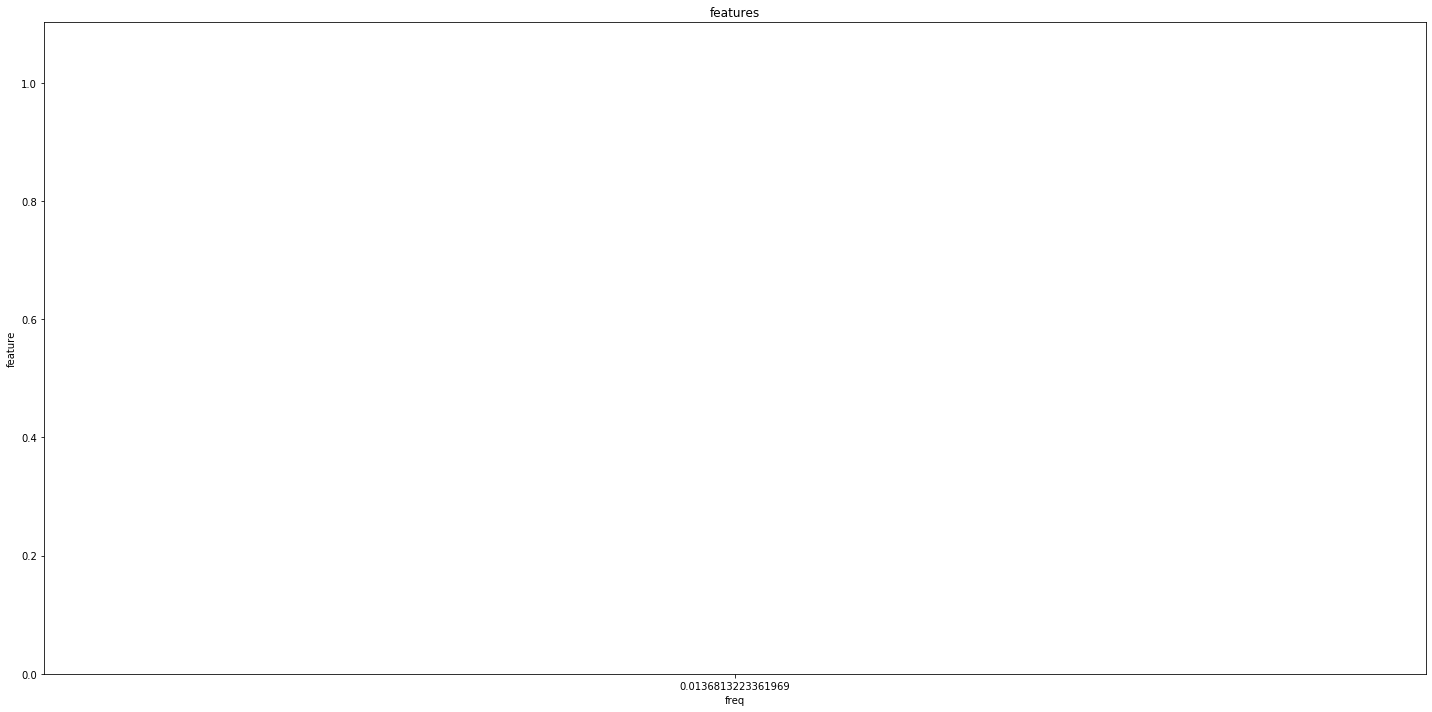

In [14]:
from mlrun import run_local, NewTask

run = run_local(NewTask(**task_params),
                handler=test_classifier,
                inputs={"test_set":"test_set.parquet" },
                workdir="/User/artifacts/",
                artifact_path=mlconf.artifact_path + "/test-classifier")

In [15]:
pd.read_parquet('/User/artifacts/test_set_preds.parquet').head()

OSError: Passed non-file path: /User/artifacts/test_set_preds.parquet

### remotely

In [16]:
from mlrun import NewTask
run = func.run(NewTask(**task_params), 
               inputs={"test_set":"test_set.parquet" },
               workdir="/User/artifacts",
               artifact_path="/User/artifacts/test-classifier")

[mlrun] 2020-04-28 20:57:35,722 starting run tasks - test classifier uid=9be4ca0ebff14f28b2787f004ccfb225  -> http://mlrun-api:8080
[mlrun] 2020-04-28 20:57:35,830 Job is running in the background, pod: tasks---test-classifier-dbt8d
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
[mlrun] 2020-04-28 20:57:40,432 log artifact roc at /User/artifacts/test-classifier/User/artifacts/models/sklearn_classifier/DecisionTreeClassifier.pkl/plots/roc.html, size: 42218, db: Y
[mlrun] 2020-04-28 20:57:40,580 log artifact confusion at /User/artifacts/test-classifier/User/artifacts/models/sklearn_classifier/DecisionTreeClassifier.pkl/plots//User/artifacts/models/sklearn_classifier/DecisionTreeClassifier-confusion.html, size: 21476, db: Y
[mlrun] 2020-04-28 20:57:40,815 lo

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...4ccfb225,0,Apr 28 20:57:39,completed,tasks - test classifier,host=tasks---test-classifier-dbt8dkind=jobowner=adminv3io_user=admin,test_set,label_column=labelsmodels_path=/User/artifacts/models/sklearn_classifierplots_dest=/User/artifacts/models/sklearn_classifier/plots,accuracy=0.9333333333333333avg_precscore=0.3734117820164331f1_score=0.9333333333333333rocauc=0.30864197530864196,rocconfusionfeatimpfeatimp-tbltest_set_preds-DecisionTreeClassifiertest_set_preds-LGBMClassifiertest_set_preds-LogisticRegressiontest_set_preds-RandomForestClassifiertest_set_preds-SVCtest_set_preds-XGBClassifier


to track results use .show() or .logs() or in CLI: 
!mlrun get run 9be4ca0ebff14f28b2787f004ccfb225  , !mlrun logs 9be4ca0ebff14f28b2787f004ccfb225 
[mlrun] 2020-04-28 20:57:48,365 run executed, status=completed
